In [1]:
# Environment
import gym

# Neural Networks
import torch.nn as nn
import torch

# Visualization
import matplotlib.pyplot as plt

import random
import numpy as np
import time

In [2]:
env_name = "CartPole-v1"

In [3]:
env = gym.make(env_name, render_mode="rgb_array")

In [4]:
nb_states = env.observation_space.shape[0]
nb_actions = env.action_space.n

In [5]:
nb_states, nb_actions

(4, 2)

# Create a Model Class

In [6]:
class Model(nn.Module):
    def __init__(self, nb_states, nb_hidden_nodes1, nb_hidden_nodes2, nb_actions):
        super(Model, self).__init__()

        self.sq = nn.Sequential(
            nn.Linear(nb_states, nb_hidden_nodes1),
            nn.ReLU(),
            nn.Linear(nb_hidden_nodes1, nb_hidden_nodes2),
            nn.ReLU(),
            nn.Linear(nb_hidden_nodes2, nb_actions)
        )

    def forward(self, x: torch.Tensor):
        # print("x:", x.shape, x.dtype)
        return self.sq(x)

# Fit Model Function

In [7]:
def fit_model(model: nn.Module, X: torch.Tensor, y: torch.Tensor, epochs: int):
    loss = nn.CrossEntropyLoss()
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    # print("X:", X.shape, X.dtype)

    for epoch in range(epochs):
        optim.zero_grad()
        
        y_pred = model(X)

        cost = loss(y, y_pred)
        cost.backward()

        optim.step()

    return model

# Hyper Parameters

In [8]:
nb_episodes = 1_000
nb_steps = 100

gamma = 0.99

epsilon = 1
epsilon_decay = 0.002
epsilon_min = 0.01

max_mem_size = 100_000

minibatch_size = 32

# Replay Function

In [9]:
def replay(replay_memory, minibatch_size):
    minibatch = np.random.choice(replay_memory, minibatch_size, replace=True)

    # Get all the states, actions, rewards, next_states, dones as arrays
    array_state =      np.array(list(map(lambda x: x["state"], minibatch)))
    array_action =     np.array(list(map(lambda x: x["action"], minibatch)))
    array_reward =     np.array(list(map(lambda x: x["reward"], minibatch)))
    array_next_state = np.array(list(map(lambda x: x["next_state"], minibatch)))
    array_done =       np.array(list(map(lambda x: x["done"], minibatch)))

    pred_next_state_actions = model( torch.tensor(array_next_state) )

    state_actions = model( torch.tensor(array_state) )

    for i, (state, action, reward, next_state, done) in enumerate(
        zip(array_state, array_action, array_reward, pred_next_state_actions, array_done)
    ):
        if not done:
            target = reward + gamma * torch.max(next_state) # torch.max(next_state) is the action
        else:
            target = reward

        state_actions[i][action] = target

    # print("array_state:", array_state.shape, array_state.dtype)
    # print("state_actions:", state_actions.shape, state_actions.dtype)

    return fit_model(model, torch.tensor(array_state), state_actions, epochs=1)

# Training

In [10]:
model = Model(nb_states, 32, 32, nb_actions)

In [11]:
verbose_freq = 1 / 20

In [12]:
replay_memory = []
all_episode_rewards = []

for episode in range(nb_episodes):
    state = env.reset()[0]
    episode_reward = 0
    
    for step in range(nb_steps):
        if np.random.uniform(0, 1) < epsilon: # EXPLORATION
            action = random.randrange(0, nb_actions)
        else:
            action = model( torch.tensor(state) ).detach().numpy().argmax()    # EXPLOITATION

        # Apply the actin to the environment
        next_state, reward, done, truncated, info = env.step(action)
        replay_memory.append({"state": state, "action": action, "reward": reward, "next_state": next_state, "done": done})
        episode_reward += reward

        if len(replay_memory) > max_mem_size:
            replay_memory.pop(0)

        model = replay(replay_memory, minibatch_size=32)

        if done:
            break

        state = next_state

    # Record Episode Rewards
    all_episode_rewards.append(episode_reward)

    # Decay the epsilon
    epsilon = max(epsilon - epsilon_decay, epsilon_min)

    # print(episode)
    if episode % int(nb_episodes * verbose_freq) == 0:
        print(f"{(episode/nb_episodes) * 100:.1f}% | Episode: {episode} | Epsilon: {epsilon:.3f} | Avg. Reward: {np.mean(all_episode_rewards[-int(nb_episodes * verbose_freq):])}")

0.0% | Episode: 0 | Epsilon: 0.998 | Avg. Reward: 14.0
5.0% | Episode: 50 | Epsilon: 0.898 | Avg. Reward: 24.48
10.0% | Episode: 100 | Epsilon: 0.798 | Avg. Reward: 20.66
15.0% | Episode: 150 | Epsilon: 0.698 | Avg. Reward: 19.18
20.0% | Episode: 200 | Epsilon: 0.598 | Avg. Reward: 15.76
25.0% | Episode: 250 | Epsilon: 0.498 | Avg. Reward: 15.32
30.0% | Episode: 300 | Epsilon: 0.398 | Avg. Reward: 13.62
35.0% | Episode: 350 | Epsilon: 0.298 | Avg. Reward: 11.66
40.0% | Episode: 400 | Epsilon: 0.198 | Avg. Reward: 10.8
45.0% | Episode: 450 | Epsilon: 0.098 | Avg. Reward: 9.96
50.0% | Episode: 500 | Epsilon: 0.010 | Avg. Reward: 9.76
55.0% | Episode: 550 | Epsilon: 0.010 | Avg. Reward: 9.48
60.0% | Episode: 600 | Epsilon: 0.010 | Avg. Reward: 9.48
65.0% | Episode: 650 | Epsilon: 0.010 | Avg. Reward: 9.7
70.0% | Episode: 700 | Epsilon: 0.010 | Avg. Reward: 9.42
75.0% | Episode: 750 | Epsilon: 0.010 | Avg. Reward: 9.52
80.0% | Episode: 800 | Epsilon: 0.010 | Avg. Reward: 9.38
85.0% | Episo

# Plotting the Rewards

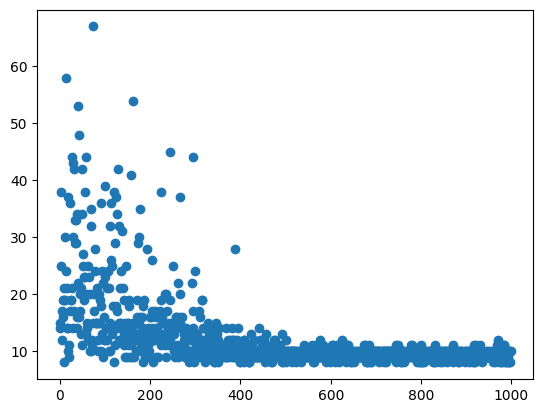

In [13]:
plt.scatter([i for i in range(len(all_episode_rewards))], all_episode_rewards)

plt.show()

# Visualizing The Agent while Playing

In [17]:
env = gym.make(env_name, render_mode="human")

In [18]:
nb_test_episodes = 1
nb_test_step = 100

In [19]:
for episode in range(nb_test_episodes):
    state = env.reset()[0]
    
    for step in range(nb_test_step):
        env.render()
        time.sleep(0.3)

        action = model( torch.tensor(state) ).detach().numpy().argmax()

        next_state, reward, done, truncated, info = env.step(action)

        if done:
            break
        
        state = next_state

env.close()